In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.datasets import make_regression
from formulaic import Formula

import matplotlib.pyplot as plt


/home/matias/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Colinealidad y explosión de coeficientes

Para cada una de los conjuntos de datos A y B, calcular los coeficientes de regresión por mínimos cuadrados al ajustar la variable y.

In [2]:
X_A = np.array([[1], [0.001], [0.001]])
X_B = np.array([[1, 1.001], [0.001, 0.001], [0.001, 0.001]])
y = np.array([1,0,0])
display(X_A)
display(X_B)
display(y)

array([[1.   ],
       [0.001],
       [0.001]])

array([[1.000e+00, 1.001e+00],
       [1.000e-03, 1.000e-03],
       [1.000e-03, 1.000e-03]])

array([1, 0, 0])

In [3]:
# Modelo A
modeloA = linear_model.LinearRegression(fit_intercept = False) 
modeloA.fit(X_A, y)
modeloA.coef_

array([0.999998])

In [4]:
# Modelo B
modeloA = linear_model.LinearRegression(fit_intercept = False) 
modeloA.fit(X_B, y)
modeloA.coef_

array([-1000.,  1000.])

## Un error común que genera colinealidad
Si tenemos una columna constante en la matriz X y usamos también intercept al hacer el ajuste, vamos a tener colinealidad y podemos obtener resultados catastróficos.

Enseguida vamos a ver este ejemplo en detalle, pero veamos ahora qué pasa si usamos dos intercepts...

In [5]:
# medv: valor medio de las propiedades (mediana)
data = pd.read_csv("dataset/BostonHousing.csv")
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)'
y, X =  Formula(formula).get_model_matrix(data)
y = y.squeeze()
display(X.shape)
display(X.head())

(506, 92)

,Intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,...,rad:tax,rad:ptratio,rad:lstat,rad:b,tax:ptratio,tax:lstat,tax:b,ptratio:lstat,ptratio:b,lstat:b
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,...,296,15.3,4.98,396.90,4528.8,1474.08,117482.40,76.194,6072.570,1976.5620
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,...,484,35.6,18.28,793.80,4307.6,2211.88,96049.80,162.692,7064.820,3627.6660
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,...,484,35.6,8.06,785.66,4307.6,975.26,95064.86,71.734,6992.374,1583.1049
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,...,666,56.1,8.82,1183.89,4151.4,652.68,87607.86,54.978,7379.581,1160.2122
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,...,666,56.1,15.99,1190.70,4151.4,1183.26,88111.80,99.671,7422.030,2115.4770


In [6]:
# Separamos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Si no agregamos ninguna opción, el programa va a agregar un nuevo intercept al realizar la regresión.
modelo = linear_model.LinearRegression() 

# Train the model
modelo.fit(X_train, y_train)

# Make predictions
y_pred = modelo.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

print(modelo.intercept_)
print(modelo.coef_[0:5])

Mean Squared Error: 427.08
11989164430.099472
[-1.19891645e+10 -3.87381529e+01  4.15602731e+00  7.28424922e+00
 -2.82104391e-01]


Obtuvimos valores altísimos para el intecept.

In [7]:
# No agregamos el intercept al realizar la regresión.
modelo = linear_model.LinearRegression(fit_intercept = False) 

# Train the model
modelo.fit(X_train, y_train)

# Make predictions
y_pred = modelo.predict(X_test)

# Evaluate the model using mean squared error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz del Error Cuadratico Medio: {rmse:.2f}")

print(modelo.intercept_)
print(modelo.coef_[0:5])

Raiz del Error Cuadratico Medio: 6.94
0.0
[ 16.22007767 -41.2433177    4.25261255   7.90079499  -0.14417319]


In [8]:
r2_score(y_test, y_pred)

0.4388365352500687

En el primer caso obtuvimos coeficientes altísimos con signos opuestos para el intercept. Los demás coeficientes también se vieron afectados y la capacidad predictiva empeoró drásticametne.

# Mínimos cuadrados regularizados

Consideramos datos de los precios de viviendas en distintos barrios de Boston. Queremos predecir el precio en función de datos demográficos de cada barrio.

In [11]:
data = pd.read_csv("dataset/BostonHousing.csv")
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Primero, modelo lineal

In [12]:
# Consideramos primero un modelo lineal con todas las variables
formula = 'medv ~ crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b'
y, X =  Formula(formula).get_model_matrix(data)
y = y.squeeze()

In [13]:
# Separamos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Regresión lineal
modeloLineal = linear_model.LinearRegression(fit_intercept = False)  # alpha is the hyperparameter equivalent to lambda

# Entrenamos el modelo
modeloLineal.fit(X_train, y_train)

# Hacemos las predicciones
y_pred = modeloLineal.predict(X_test)

# Evaluamos el desempeño del modelo
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raiz del Error Cuadratico Medio: {rmse:.5f}")

Raiz del Error Cuadratico Medio: 4.92860


Como tenemos datos poblaciones, puede ser útil considerar interacciones, por ejemplo tiene sentido multiplicar cantidad de habitantes por salario promedio.

Sin pensarlo mucho ni mirar mucho las variables, incorporamos las interacciones entre las variables para ver si podemos mejorar el modelo.

In [15]:
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)'
y, X =  Formula(formula).get_model_matrix(data)
X.head()

,Intercept,crim,zn,indus,chas,nox,rm,age,dis,rad,...,rad:tax,rad:ptratio,rad:lstat,rad:b,tax:ptratio,tax:lstat,tax:b,ptratio:lstat,ptratio:b,lstat:b
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,...,296,15.3,4.98,396.90,4528.8,1474.08,117482.40,76.194,6072.570,1976.5620
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,...,484,35.6,18.28,793.80,4307.6,2211.88,96049.80,162.692,7064.820,3627.6660
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,...,484,35.6,8.06,785.66,4307.6,975.26,95064.86,71.734,6992.374,1583.1049
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,...,666,56.1,8.82,1183.89,4151.4,652.68,87607.86,54.978,7379.581,1160.2122
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,...,666,56.1,15.99,1190.70,4151.4,1183.26,88111.80,99.671,7422.030,2115.4770


In [16]:
# Separamos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Inicializamos el modelo lineal
modeloLineal = linear_model.LinearRegression(fit_intercept = False)  # alpha is the hyperparameter equivalent to lambda

# Entrenamiento
modeloLineal.fit(X_train, y_train)

# Predicciones
y_pred = modeloLineal.predict(X_test)

# Evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Raíz del Error Cuadrático Medio: {rmse:.5f}")

Raíz del Error Cuadrático Medio: 3.38172


Logramos una reducción importante del error cuadrático.

**Ejercicio:** Mirando los coeficientes con cuidado, seleccionar cuáles interacciones son importantes, y utilizar las técnicas vistas de selección de modelos, seleccionar un modelo lineal con pocas variables y similar poder explicativo.

Al introducir tantas variables nuevas, relacionadas con las variables originales, es muy posible que hayamos introducido colinealidad entre las variables.

Es razonable entonces intentar un modelo de mínimos cuadrados regularizados.

**Paso 1:** Separamos los datos en entrenamiento y testeo.

In [18]:
# Entrenamiento y testeo
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Construimos las matrices X e y para entrenamiento
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)'
y, X =  Formula(formula).get_model_matrix(df_train)

**Paso 2:** Definimos un vector de parámetros a probar

In [19]:
alphas = np.array([0.01, 0.1, 0.5, 1, 2, 3])
alphas.size

6

**Pasos 3 y 4:** Para cada valor de alpha, calculamos el error promedio al realizar validación cruzada de 5 pliegos en los datos de entrenamiento.

In [20]:
# Comenzamos con un valor de alpha fijo
alpha = alphas[0]  # alpha = 0.01

cv = KFold(n_splits=5, random_state=42, shuffle=True)  # 5 pliegos

modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

ind = 0

# Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
for train_index, val_index in cv.split(X):
    X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
    modeloRidge.fit(X_train, y_train)
    
    y_pred = modeloRidge.predict(X_val)
    rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
    ind = ind + 1

print(f"Raiz cuadrada del Mean Squared Error: {rmse.mean():.2f}")

Raiz cuadrada del Mean Squared Error: 4.63


Esto lo hicimos para un solor valor de alpha, podemos hacerlo fácilmente para varios valores.

In [21]:
for alpha in alphas:
    # Inicializamos un modelo de Regresion Lineal sin intercept
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raíz del Error Cuadratico Medio es: {rmse.mean():.5f}")

Para alpha = 0.01000 la raíz del Error Cuadratico Medio es: 4.62878
Para alpha = 0.10000 la raíz del Error Cuadratico Medio es: 4.56949
Para alpha = 0.50000 la raíz del Error Cuadratico Medio es: 4.54304
Para alpha = 1.00000 la raíz del Error Cuadratico Medio es: 4.55236
Para alpha = 2.00000 la raíz del Error Cuadratico Medio es: 4.56598
Para alpha = 3.00000 la raíz del Error Cuadratico Medio es: 4.57144


El valor óptimo es alpha = 0.5.
En base a los resultados observados agregamos algunos valores de alpha cercanos a 0.5.

In [22]:
alphas = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1, 2, 3])

for alpha in alphas:
    modeloRidge = linear_model.Ridge(alpha = alpha, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
    rmse = np.zeros(cv.get_n_splits())  # Vamos a guardar el error en cada pliego

    ind = 0

    # Para seleccionar algunas filas dados los índices, utilizamos iloc (lo vimos en la clase 2)
    for train_index, val_index in cv.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        modeloRidge.fit(X_train, y_train)

        y_pred = modeloRidge.predict(X_val)
        rmse[ind] = np.sqrt(mean_squared_error(y_val, y_pred))
        ind = ind + 1

    print(f"Para alpha = {alpha:.5f} la raiz del error cuadratico medio es: {rmse.mean():.5f}")


Para alpha = 0.10000 la raiz del error cuadratico medio es: 4.56949
Para alpha = 0.20000 la raiz del error cuadratico medio es: 4.55082
Para alpha = 0.30000 la raiz del error cuadratico medio es: 4.54444
Para alpha = 0.40000 la raiz del error cuadratico medio es: 4.54267
Para alpha = 0.50000 la raiz del error cuadratico medio es: 4.54304
Para alpha = 0.60000 la raiz del error cuadratico medio es: 4.54442
Para alpha = 0.70000 la raiz del error cuadratico medio es: 4.54627
Para alpha = 1.00000 la raiz del error cuadratico medio es: 4.55236
Para alpha = 2.00000 la raiz del error cuadratico medio es: 4.56598
Para alpha = 3.00000 la raiz del error cuadratico medio es: 4.57144


Obtuvimos el valor más chico para $\alpha = 0.4$. 

Fijamos este valor y ajustamos el modelo usando todos los datos.

**Importante:** 
1. Los coeficientes de la regresión son **parámetros** y se recalculan utilizando todos los datos.
2. El coeficiente $\alpha$ es un **hiperparámetro**, queda fijo y no se recalcula.

In [23]:
alpha_optimo = 0.4

modeloRidge = linear_model.Ridge(alpha = alpha_optimo, fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modeloRidge.fit(X, y)

Ridge(alpha=0.4, fit_intercept=False)

Probamos el modelo obtenido en los datos de testeo.

In [24]:
# Construimos las matrices X e y para entrenamiento
formula = 'medv ~ (crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)*(crim+zn+indus+chas+nox+rm+age+dis+rad+tax+ptratio+lstat+b)'
y_test, X_test =  Formula(formula).get_model_matrix(df_test)
        
y_pred = modeloRidge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"For alpha = {alpha_optimo:.5f} the Root Mean Squared Error is: {rmse.mean():.5f}")

For alpha = 0.40000 the Root Mean Squared Error is: 3.36832


Obtuvimos un error menor!

Podemos comparar los coeficientes gráficamente:

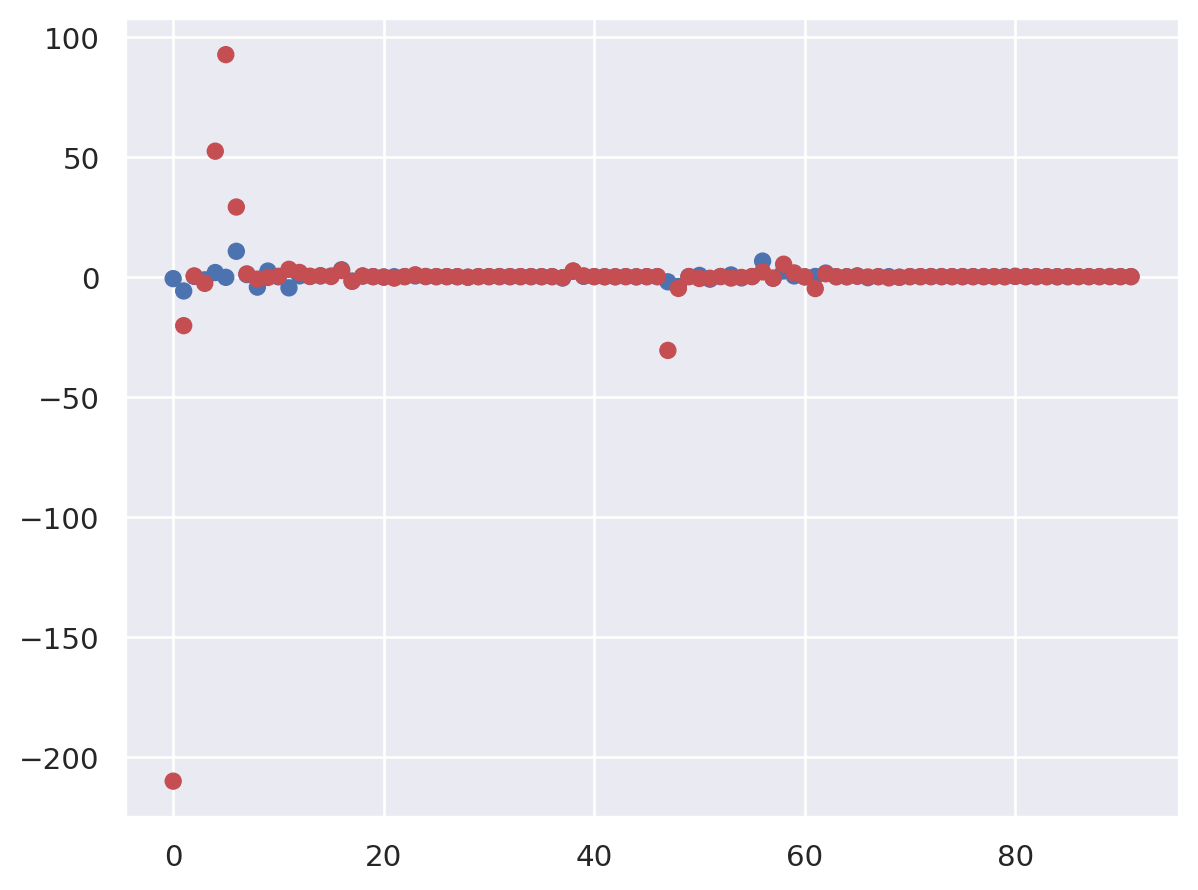

In [25]:
(
    so.Plot(x = np.arange(X.shape[1]))
    .add(so.Dot(color = "b"), y = modeloRidge.coef_.squeeze())
    .add(so.Dot(color = "r"), y = modeloLineal.coef_.squeeze())
)

Los azules son los valores de Ridge
Lo rojos son los de nuestra predicion anterior.

Vemos que muchos valores que antes modificaban mucho la ecuacion, ahora no modifican tanto, es decir que mejoramos la eficiencia de nuestro codigo gracias a Ridge